# Lab 3

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## Lab 3.1 - Logistic Regression

In [3]:
# This dataset describes grains of rice in terms of visual properties.
# The class is the variety of rice, either Cammeo or Osmancık
# https://archive.ics.uci.edu/ml/datasets/Rice+%28Cammeo+and+Osmancik%29
# (Actually downloaded the data from the paper's website.)
rice = pd.read_csv("Rice_Osmancik_Cammeo_Dataset.csv")
rice.head()

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


In [4]:
# Check out class distribution

rice.CLASS.value_counts()

Osmancik    2180
Cammeo      1630
Name: CLASS, dtype: int64

In [6]:
#Baseline accuracy?

baselineacc = 2180 / (2180 + 1630)
print(baselineacc)

0.5721784776902887


In [7]:
# Split data, train logistic regression

X = rice.drop('CLASS', axis='columns').values
y = rice.CLASS.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=0)

In [8]:
# Fit model, print coefficients
RICELR = LogisticRegression(penalty='none')
ricelr = RICELR.fit(Xtrain,ytrain)

print(f"Intercept {ricelr.intercept_} \nCoefficients: {ricelr.coef_}")


Intercept [0.00318845] 
Coefficients: [[ 0.00608732  0.14475211 -0.24051264  0.39193589  0.00145249 -0.01007885
   0.003195  ]]


In [10]:
# Predict manually
sigmoid = lambda x: 1 / (1 + np.exp(-x))
z = np.dot(Xtest,ricelr.coef_.T) + ricelr.intercept_
z

array([[  3.34226677],
       [-10.37898789],
       [ -0.09896634],
       ...,
       [ -4.0019276 ],
       [  1.71460141],
       [ -8.58612399]])

In [11]:
sigmoid(z)

array([[9.65850686e-01],
       [3.10777332e-05],
       [4.75278589e-01],
       ...,
       [1.79521950e-02],
       [8.47432156e-01],
       [1.86643411e-04]])

In [12]:
# Predict on test
ricelr.predict_proba(Xtest)

array([[3.41493136e-02, 9.65850686e-01],
       [9.99968922e-01, 3.10777332e-05],
       [5.24721411e-01, 4.75278589e-01],
       ...,
       [9.82047805e-01, 1.79521950e-02],
       [1.52567844e-01, 8.47432156e-01],
       [9.99813357e-01, 1.86643411e-04]])

In [14]:
# Get label predictions - how does this function work?
ytest_hat = ricelr.predict(Xtest)
ytest_hat

array(['Osmancik', 'Cammeo', 'Cammeo', ..., 'Cammeo', 'Osmancik',
       'Cammeo'], dtype=object)

## Lab 3.2 - Evaluating Classifiers

In [16]:
# Calculate performance measures from scratch
# TP: true postives 
# TN: true negatives 
# FP: False positives 
# FN: False negatives
def compute_performance(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    # Print results
    
    print("Accuracy:",round(acc,3),"Recall:",round(recall,3),"Precision:",round(precision,3),
          "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))

compute_performance(ytest_hat, ytest, ricelr.classes_)

tp: 1001 tn: 773 fp: 81 fn: 50
Accuracy: 0.931 Recall: 0.952 Precision: 0.925 Sensitivity: 0.952 Specificity: 0.905


In [22]:
# Now let's experiment by adjusting the decision threshold
ytest_prob = ricelr.predict_proba(Xtest)
yhat = ricelr.classes_[(ytest_prob[:,1]>0.1).astype(int)]

compute_performance(yhat, ytest, ricelr.classes_)

tp: 1040 tn: 613 fp: 241 fn: 11
Accuracy: 0.868 Recall: 0.99 Precision: 0.812 Sensitivity: 0.99 Specificity: 0.718


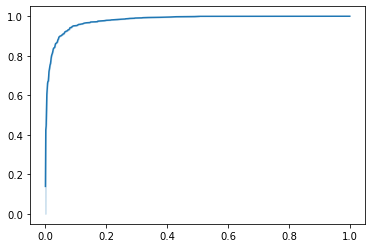

In [23]:
# ROC using sklearns ROC curve. 
fpr, tpr, _ = roc_curve(ytest, ytest_prob[:,1], pos_label="Osmancik")
ax=sns.lineplot(fpr,tpr)

In [24]:
# AUROC
auc(fpr,tpr)

0.9801115030404856

## Lab 3.3 - Multiclass Logistic Regression

In [25]:
# Read data
iris = pd.read_csv("iris.csv")
iris.head()

,Sepal-length,Sepal-width,Petal-length,Petal-width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [26]:
# Check out class distribution
iris.Species.value_counts()

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: Species, dtype: int64

In [27]:
# Create y and X. Not going to split these data for this demonstration.
y = iris.Species.valuesd
X = iris.drop("Species", axis="columns")

In [44]:
# Note that unlike our convention in class, sklearn makes a parameter vector
# for every class (not just first K-1) even though it is redundant.
# Try this with regularization too

IRISLR = LogisticRegression(penalty='l2',solver='newton-cg',C=0.01)
irislr = IRISLR.fit(X,y)
print(f"Intercepts: {irislr.intercept_} \nCoefficients: {irislr.coef_}")

Intercepts: [ 2.19258938  0.21853297 -2.41112235] 
Coefficients: [[-0.13682448  0.096067   -0.43483505 -0.17832092]
 [-0.00099744 -0.10239728  0.08665839 -0.00340217]
 [ 0.13782191  0.00633028  0.34817665  0.18172309]]


In [45]:
# Note that sklearn uses rows to indicate truth, columns to indicate prediction, unlike our convention
# So transpose it.
yhat = irislr.predict(X)
yhat_probs = irislr.predict_proba(X)


In [46]:
confusion_matrix(yhat,y).T

array([[50,  0,  0],
       [ 1, 32, 17],
       [ 0,  1, 49]])